# generate_cuped_binary_26

The `make_cuped_binary_26` data generating process (DGP) creates a synthetic binary-outcome dataset with randomized treatment, richer confounders, structured heterogeneous treatment effects (HTE), and a calibrated pre-period covariate (`y_pre`) for CUPED benchmarking.

# 1. Confounders


The DGP uses mixed-type confounders sampled from independent marginals:
- `tenure_months` ($X_1$): $\text{Lognormal}(\mu=2.5, \sigma=0.5)$
- `spend_last_month` ($X_2$): $\text{Lognormal}(\mu=4.0, \sigma=0.8)$
- `discount_rate` ($X_3$): $\text{Beta}(\text{mean}=0.1, \kappa=20)$
- `support_tickets` ($X_4$): $\text{Poisson}(\lambda=1.8)$
- `email_open_rate` ($X_5$): $\text{Beta}(\text{mean}=0.45, \kappa=14)$
- `referral_count` ($X_6$): $\text{Poisson}(\lambda=0.8)$
- `plan_tier` ($X_7$): Categorical with levels `free` (55%), `plus` (30%), `pro` (15%), encoded as `plan_tier_plus` and `plan_tier_pro`.
- `region` ($X_8$): Categorical with levels `na` (80%), `eu` (20%), encoded as `region_eu`.


# 2. Treatment Assignment


Treatment is randomized with constant propensity:
$$D \sim \text{Bernoulli}(0.5)$$
This is implemented with $\alpha_d = \text{logit}(0.5)$ and no $X$- or latent-driven treatment terms.


# 3. Outcome Model

The outcome is binary with a logistic link:
$$Y \sim \text{Bernoulli}(p), \quad \text{logit}(p)=\alpha_y + g_y(X) + \lambda U + D \cdot \tau(X)$$
- $\alpha_y=-1.4$.
- $U \sim \mathcal{N}(0,1)$ is a shared latent prognostic signal used only in the outcome equation (so treatment remains randomized/unconfounded).
- $\lambda=1.2$ when `add_pre=True`, and $\lambda=0$ otherwise.
- Baseline score $g_y(X)$ combines monotone transformations of confounders and segment indicators.


# 4. Heterogeneous Treatment Effect


Treatment effect is defined on the log-odds scale:
$$\tau(X)=\text{clip}(\theta_{logit} \cdot g_t \cdot g_{sp} \cdot g_o \cdot g_{ticket} \cdot g_{ref} \cdot seg, 0, 2\theta_{logit})$$
Where:
- $g_t = \sigma(0.20 \cdot (\text{tenure} - 10))$
- $g_{sp} = \sigma(0.55 \cdot (\log(1+\text{spend}) - 4))$
- $g_o = 0.85 + 0.35 \cdot \text{email\_open\_rate}$
- $g_{ticket} = \frac{1}{1+\exp(0.45 \cdot (\text{support\_tickets}-2.5))}$
- $g_{ref} = 0.90 + 0.18 \cdot \tanh(0.8 \cdot \text{referral\_count})$
- $seg = 1 + 0.12\,\mathbb{1}_{plan=plus} + 0.26\,\mathbb{1}_{plan=pro} + 0.06\,\mathbb{1}_{region=eu}$
- $\theta_{logit}=0.38$ by default.


# 5. Pre-period Covariate


If `add_pre=True`, first define a centered probability-scale baseline signal:
$$s(X,U)=\sigma\!\left(\alpha_y + g_y(X) + \lambda U\right)-\mathbb{E}\left[\sigma\!\left(\alpha_y + g_y(X) + \lambda U\right)\right]$$
Then construct:
$$y_{pre}=s(X,U)+\sigma_{noise}\epsilon, \quad \epsilon \sim \mathcal{N}(0,1)$$
The noise scale is calibrated numerically so that $\text{corr}(y_{pre}, y)$ in the control group matches the target correlation (default $0.65$).

In [1]:
from causalis.scenarios.cuped.dgp import make_cuped_binary_26
from causalis.data_contracts import CausalData

data = make_cuped_binary_26(return_causal_data=False, include_oracle=True, theta_logit=0.38, pre_target_corr=0.65)
data.head()


,y,d,tenure_months,spend_last_month,discount_rate,support_tickets,email_open_rate,referral_count,plan_tier_plus,plan_tier_pro,region_eu,m,m_obs,tau_link,g0,g1,cate,y_pre
0,0.0,0.0,14.187461,62.867015,0.087395,2.0,0.412214,2.0,0.0,0.0,0.0,0.5,0.5,0.081508,0.267699,0.280682,0.012983,0.009942
1,0.0,0.0,7.242801,112.089626,0.173939,2.0,0.131957,0.0,0.0,0.0,0.0,0.5,0.5,0.037301,0.223180,0.228483,0.005303,-0.220081
2,1.0,1.0,17.729423,16.813523,0.141900,2.0,0.376393,0.0,1.0,0.0,0.0,0.5,0.5,0.060442,0.245717,0.254861,0.009144,0.096021
3,0.0,0.0,19.497424,43.456545,0.146694,2.0,0.680602,1.0,0.0,0.0,0.0,0.5,0.5,0.096195,0.269024,0.284422,0.015398,0.188115
4,0.0,0.0,4.592766,105.987656,0.112326,6.0,0.642113,0.0,1.0,0.0,1.0,0.5,0.5,0.011141,0.264030,0.265771,0.001741,-0.250511


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")


Ground truth ATE is 0.011857450138243646
Ground truth ATTE is 0.011877088659875997


In [3]:
causaldata = CausalData(df=data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months', 'spend_last_month', 'discount_rate', 'support_tickets', 'email_open_rate', 'referral_count', 'plan_tier_plus', 'plan_tier_pro', 'region_eu', 'y_pre'])
causaldata


CausalData(df=(10000, 12), treatment='d', outcome='y', confounders=['tenure_months', 'spend_last_month', 'discount_rate', 'support_tickets', 'email_open_rate', 'referral_count', 'plan_tier_plus', 'plan_tier_pro', 'region_eu', 'y_pre'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)


,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,5034,0.276917,0.447520,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,1.0,4966,0.298027,0.457437,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [5]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)


,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,region_eu,0.210369,0.189086,0.021284,-0.053250,0.20331
1,spend_last_month,77.921167,75.111595,2.809573,-0.039381,0.68313
2,plan_tier_pro,0.151569,0.161095,0.009526,0.026230,0.97481
3,support_tickets,1.817839,1.789569,0.028270,-0.020930,0.72761
4,referral_count,0.797378,0.785139,0.012239,-0.013696,1.00000
5,tenure_months,13.780500,13.732216,0.048284,-0.006523,0.69284
6,plan_tier_plus,0.298967,0.296214,0.002753,-0.006020,1.00000
7,discount_rate,0.100375,0.100514,0.000139,0.002123,0.34966
8,y_pre,-0.000064,0.000065,0.000129,0.000612,0.64056
9,email_open_rate,0.447786,0.447805,0.000020,0.000155,0.95826


In [6]:
from causalis.shared import outcome_plot_dist

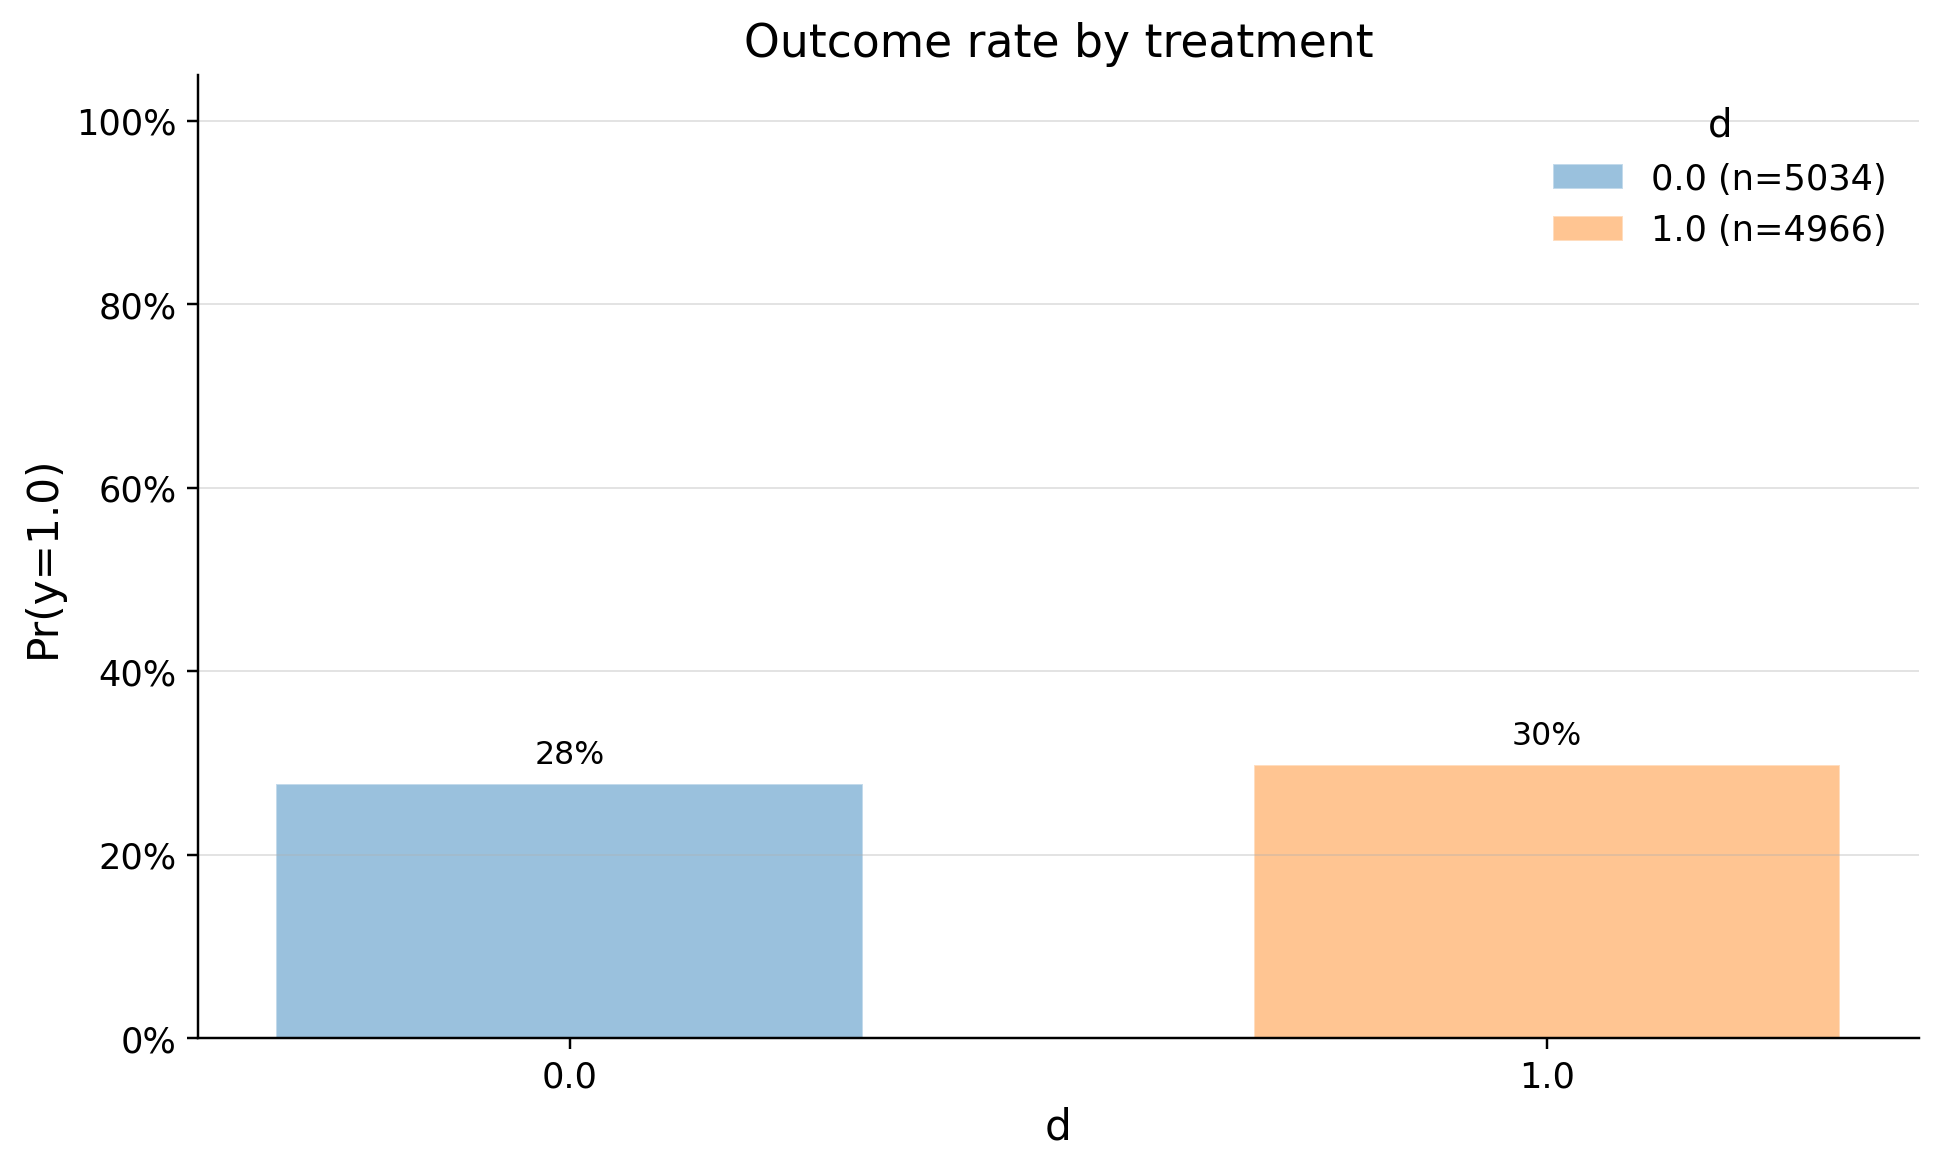

In [7]:
outcome_plot_dist(causaldata)
